# Table of Contents
* [PDF parsing experiments](#PDF-parsing-experiments)
	* [pdfminer](#pdfminer)
	* [pdfminer drawing boxes](#pdfminer-drawing-boxes)
	* [Minecart + poppler direct](#Minecart-+-poppler-direct)
	* [tables of content extraction](#tables-of-content-extraction)
* [Image extraction](#Image-extraction)
* [CK12 flexbook pdf extraction](#CK12-flexbook-pdf-extraction)
	* [freq distribution](#freq-distribution)
* [Workbook extraction](#Workbook-extraction)
* [Quiz and test extraction](#Quiz-and-test-extraction)
* [Joining flexbook and workbooks](#Joining-flexbook-and-workbooks)
	* [Dataset verification](#Dataset-verification)
* [modules and quizes](#modules-and-quizes)
	* [weird misses](#weird-misses)
	* [verify](#verify)
* [combining lessons and flexbook content](#combining-lessons-and-flexbook-content)
* [Lower grade levels](#Lower-grade-levels)
* [renaming files to match v0.91](#renaming-files-to-match-v0.91)
* [End](#End)


In [346]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams, LTTextBox, LTTextLine, LTFigure, LTImage

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# if libpoppler import fails on the openjpeg lib, add a link from celler version to the local lib dir
import pdfextraction.ck12_flex_extract as ck_ex

# PDF parsing experiments

## pdfminer

In [440]:
page_size = []
with open(test_file, 'r') as fp:
    parser = PDFParser(fp)
    document = PDFDocument(parser)
    
    for page_n, page in enumerate(PDFPage.create_pages(document)):
        page_size = page.mediabox[2:]

In [5]:
test_page_layout[0]._objs

[<LTTextBoxHorizontal(0) 54.000,761.451,117.927,775.272 u'www.ck12.org\n'>,
 <LTTextBoxHorizontal(1) 436.386,761.451,555.273,775.272 u'Chapter 4. Cell Functions\n'>,
 <LTTextBoxHorizontal(2) 98.382,694.737,236.200,725.331 u'4.1 Transport\n'>,
 <LTTextBoxHorizontal(3) 54.000,610.841,168.099,627.859 u'Lesson Objectives\n'>,
 <LTTextBoxHorizontal(4) 72.000,557.794,278.073,598.714 u'\u2022 Describe the structure of the cell membrane.\n\u2022 Identify ways that passive transport occurs.\n\u2022 De\ufb01ne and give examples of active transport.\n'>,
 <LTTextBoxHorizontal(5) 54.000,496.318,171.107,513.336 u'Lesson Vocabulary\n'>,
 <LTTextBoxHorizontal(6) 72.000,348.427,166.636,484.191 u'\u2022 active transport\n\u2022 concentration\n\u2022 diffusion\n\u2022 facilitated diffusion\n\u2022 osmosis\n\u2022 passive transport\n\u2022 simple diffusion\n\u2022 transport\n\u2022 transport protein\n\u2022 vesicle transport\n'>,
 <LTTextBoxHorizontal(7) 54.000,286.951,129.055,303.969 u'Introduction\n'>,

In [13]:
test_page_layout[0]._objs[-4]

{'bbox': (54.0, 723.20454, 558.0065, 723.20454),
 'height': 0.0,
 'linewidth': 1.99255,
 'pts': [(54.0, 723.20454), (558.0065, 723.20454)],
 'width': 504.00649999999996,
 'x0': 54.0,
 'x1': 558.0065,
 'y0': 723.20454,
 'y1': 723.20454}

In [7]:
test_char_ext = test_page_layout[0]._objs[0]._objs[0]._objs[0]

In [17]:
test_char_ext.fontsize.__dict__

{'ascent': 924,
 'basefont': 'XCRUNF+NimbusRomNo9L-Regu',
 'bbox': [-199, -312, 1031, 955],
 'cid2unicode': {32: u' ',
  33: u'!',
  34: u'"',
  35: u'#',
  36: u'$',
  37: u'%',
  38: u'&',
  39: u"'",
  40: u'(',
  41: u')',
  42: u'*',
  43: u'+',
  44: u',',
  45: u'-',
  46: u'.',
  47: u'/',
  48: u'0',
  49: u'1',
  50: u'2',
  51: u'3',
  52: u'4',
  53: u'5',
  54: u'6',
  55: u'7',
  56: u'8',
  57: u'9',
  58: u':',
  59: u';',
  60: u'<',
  61: u'=',
  62: u'>',
  63: u'?',
  64: u'@',
  65: u'A',
  66: u'B',
  67: u'C',
  68: u'D',
  69: u'E',
  70: u'F',
  71: u'G',
  72: u'H',
  73: u'I',
  74: u'J',
  75: u'K',
  76: u'L',
  77: u'M',
  78: u'N',
  79: u'O',
  80: u'P',
  81: u'Q',
  82: u'R',
  83: u'S',
  84: u'T',
  85: u'U',
  86: u'V',
  87: u'W',
  88: u'X',
  89: u'Y',
  90: u'Z',
  91: u'[',
  92: u'\\',
  93: u']',
  94: u'^',
  95: u'_',
  96: u'`',
  97: u'a',
  98: u'b',
  99: u'c',
  100: u'd',
  101: u'e',
  102: u'f',
  103: u'g',
  104: u'h',
  105: u'i'

In [12]:
dir(test_char_ext.fontsize)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'ascent',
 'basefont',
 'bbox',
 'char_disp',
 'char_width',
 'cid2unicode',
 'decode',
 'default_width',
 'descent',
 'descriptor',
 'flags',
 'fontname',
 'get_ascent',
 'get_descent',
 'get_height',
 'get_width',
 'hscale',
 'is_multibyte',
 'is_vertical',
 'italic_angle',
 'leading',
 'string_width',
 'to_unichr',
 'unicode_map',
 'vscale',
 'widths']

In [277]:
def get_deepest_nested_component(layout_comp):
    if hasattr(layout_comp, '_objs'):
        return get_first_nested_component(layout_comp._objs[0])
    else:
        return layout_comp

def check_for_topic_header(text_box, header_font):
    first_char = get_deepest_nested_component(text_box)
    if hasattr(first_char, 'fontname'):
        box_font = first_char.fontname.split('_')[-1]
        print box_font
        return box_font == header_font
    else:
        return False

def process_line(text_box):
    return check_for_topic_header(text_box)

def process_page(page_layout, header_font = 'Bold'):
    for box in page_layout:
        print box
        header_found = check_for_topic_header(box, header_font)

In [14]:
# test_page_layout[0]._objs


'KCJNMV+NimbusRomNo9L-Regu-Slant_167'

to1 = test_page_layout[0]._objs[2]._objs[0]._objs[0]

## pdfminer drawing boxes

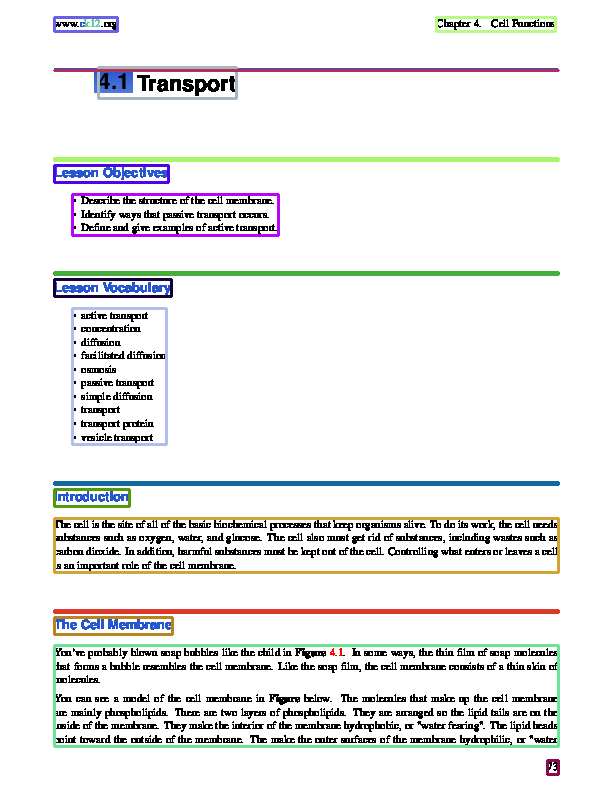

In [4]:
# pdf_processing.draw_pdf_with_boxes(test_file, [50,50])
pdf_processing.draw_pdf_with_boxes(test_file, [0,1])

## Minecart + poppler direct

In [20]:
import minecart

In [28]:
ROW_BORDERS = (
    72 * 1,  # Bottom row starts 1 inch from the bottom of the page
    72 * 3,  # Second row starts 3 inches from the bottom of the page
    72 * 5,  # Third row starts 5 inches from the bottom of the page
    72 * 7,  # Third row ends 7 inches from the bottom of the page
)
COLUMN_BORDERS = (
    72 * 8,  # Third col ends 8 inches from the left of the page
    72 * 6,  # Third col starts 6 inches from the left of the page
    72 * 4,  # Second col starts 4 inches from the left of the page   
    72 * 2,  # First col starts 2 inches from the left of the page
)  # reversed so that BOXES is ordered properly
BOXES = [
    (left, bot, right, top)
    for top, bot in zip(ROW_BORDERS, ROW_BORDERS[1:])
    for left, right in zip(COLUMN_BORDERS, COLUMN_BORDERS[1:])
]

def extract_output(page):
    """
    Reads the text from page and splits it into the 9 cells.

    Returns a list with 9 entries: 

        [A, B, C, D, E, F, G, H, I]

    Each item in the tuple contains a string with all of the
    text found in the cell.

    """
    res = []
    for box in BOXES:
        strings = list(page.letterings.iter_in_bbox(box))
        # We sort from top-to-bottom and then from left-to-right, based
        # on the strings' top left corner
        strings.sort(key=lambda x: (-x.bbox[3], x.bbox[0]))
        res.append(" ".join(strings).replace(u"\xa0", " ").strip())
    return res

In [24]:
content = []
doc = minecart.Document(open(test_file, 'rb'))

In [9]:
# for page in doc.iter_pages():
#     content.append(extract_output(page))

In [37]:
import poppler

ImportError: No module named poppler

In [33]:
import ctypes
import sys
import os.path
import poppler_page
lib_poppler = ctypes.cdll.LoadLibrary("/usr/local/Cellar/poppler/0.37.0/lib/libpoppler-glib.8.dylib")
 
ctypes.pythonapi.PyCapsule_GetPointer.restype = ctypes.c_void_p
ctypes.pythonapi.PyCapsule_GetPointer.argtypes = [ctypes.py_object, ctypes.c_char_p]
PyCapsule_GetPointer = ctypes.pythonapi.PyCapsule_GetPointer
 
class Poppler_Rectangle(ctypes.Structure):
    _fields_ = [ ("x1", ctypes.c_double), ("y1", ctypes.c_double), ("x2", ctypes.c_double), ("y2", ctypes.c_double) ]
LP_Poppler_Rectangle = ctypes.POINTER(Poppler_Rectangle)
poppler_page_get_text_layout = ctypes.CFUNCTYPE(ctypes.c_int, 
                                                ctypes.c_void_p, 
                                                ctypes.POINTER(LP_Poppler_Rectangle), 
                                                ctypes.POINTER(ctypes.c_uint)
                                                )(lib_poppler.poppler_page_get_text_layout)
 
def get_page_layout(page):
    assert isinstance(page, Poppler.Page)
    capsule = page.__gpointer__
    page_addr = PyCapsule_GetPointer(capsule, None)
    rectangles = LP_Poppler_Rectangle()
    n_rectangles = ctypes.c_uint(0)
    has_text = poppler_page_get_text_layout(page_addr, ctypes.byref(rectangles), ctypes.byref(n_rectangles))
    try:
        result = []
        if has_text:
            assert n_rectangles.value > 0, "n_rectangles.value > 0: {}".format(n_rectangles.value)
            assert rectangles, "rectangles: {}".format(rectangles)
            for i in range(n_rectangles.value):
                r = rectangles[i]
                result.append((r.x1, r.y1, r.x2, r.y2))
        return result
    finally:
        if rectangles:
            GLib.free(ctypes.addressof(rectangles.contents))
 
def main():
    
    print 'Version:', Poppler.get_version()
    path= test_file
    if not os.path.isabs(path):
        path=os.path.join(os.getcwd(), path)
    d=Poppler.Document.new_from_file('file:'+path)
    n=d.get_n_pages()
    for pg_no in range(n):
        p=d.get_page(pg_no)
        print 'Page %d' % (pg_no+1), 'size ', p.get_size()
        text=p.get_text().decode('UTF-8')
        locs=get_page_layout(p)
        fonts=p.get_text_attributes()
        offset=0
        cfont=0
        for line in text.splitlines(True):
            print ' ', line.encode('UTF-8'),
            n=len(line)
            for i in range(n):
                if line[i]==u'\n':
                    continue
                font=fonts[cfont]
                while font.start_index > i+offset or font.end_index < i+offset:
                    cfont+=1
                    if cfont>= len(fonts):
                        font=None
                        break
                    font=fonts[cfont]
                
                bb=locs[offset+i]
                print line[i].encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)' % bb,
                if font:
                    print font.font_name, font.font_size, 'r=%d g=%d, b=%d'%(font.color.red, font.color.green, font.color.blue),
            offset+=n
            print       
        print
        #p.free_text_attributes(fonts)

## tables of content extraction

In [34]:
import pdfparser.poppler as pdf
import sys
import string

In [ ]:
# test_file = text_path + earth_sci_text
# test_file = text_path + life_sci_text
# test_file = 'img_test/test_page.pdf'
# test_file = './ck12_pdfs/text/test_page_multi.pdf'

# toc_dir = 'tables_of_content/'
# etoc = 'ls_toc.pdf'
# test_file = text_path + toc_dir + etoc

In [169]:
d=pdf.Document(test_file)
etoc_lines =[]
print 'No of pages', d.no_of_pages
for p in d:
#     print 'Page', p.page_no, 'size =', p.size
    for f in p:
#         print ' '*1,'Flow'
        for b in f:
#             print ' '*2,'Block', 'bbox=', b.bbox.as_tuple()
            for l in b:
#                 print ' '*3, l.text.encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)'% l.bbox.as_tuple()
                #assert l.char_fonts.comp_ratio < 1.0
#                 print list(l.char_fonts)[0]
#                 for i in range(len(l.text)):
#                     print l.text[i].encode('UTF-8'), '(%0.2f, %0.2f, %0.2f, %0.2f)'% l.char_bboxes[i].as_tuple(),\
#                         print'(%0.2f, %0.2f, %0.2f, %0.2f)'% , \
#                 print l.text
#                 print l.char_fonts[0].size, l.char_fonts[0].color
                if l.char_fonts[0].color.as_tuple()[2] == 1.0:
                    line_text = l.text
                    if not line_text[0].isdigit():
                        line_text = line_text.replace('.','')

                    etoc_lines.append(line_text.strip().encode('ascii', 'ignore'))
#                         l.char_fonts[i].name, l.char_fonts[i].size, l.char_fonts[i].color,
#                     print '\n'
#                 print

No of pages 4


In [170]:
processed_lines = []
for idx, t_line in enumerate(etoc_lines):
    start_char = t_line[0]
    if not start_char.isdigit() and '.' in etoc_lines[idx - 1] and 'References' not in t_line and len(t_line) > 2:
        new_line = etoc_lines[idx - 1] + ' ' + t_line
        while new_line[-1].isdigit():
            new_line = new_line[:-1]
        processed_lines.append(new_line[:].strip())

In [173]:
# etoc_lines

In [72]:
pd.Series(processed_lines).to_csv('phys_sci_toc.csv', index=False)

In [212]:
for lesson, topic in parsed_flexbook.items():
    if not lesson.encode('ascii', 'ignore') in ls_toc_list:
        print lesson

In [185]:
ls_toc = pd.read_csv('./parsed_to`c/life_sci_toc.csv', header=None)
ls_toc_list = ls_toc.values.flatten().tolist()

# Image extraction

In [553]:
image_bbox = []
for ob in fig_page_layout:
    if isinstance(ob, LTFigure):
        image_bbox.append(ob.bbox)

In [560]:
tl1 = fig_page_layout[18]

In [555]:
fig_page_layout

[<LTTextBoxHorizontal(0) 54.000,761.451,101.935,775.294 u'9.2. Fungi\n'>,
 <LTTextBoxHorizontal(1) 491.346,761.451,555.273,775.272 u'www.ck12.org\n'>,
 <LTTextBoxHorizontal(2) 392.302,648.366,553.740,676.526 u'FIGURE 9.10\nSexual and asexual reproduction in fungi\n'>,
 <LTTextBoxHorizontal(3) 53.999,476.645,557.999,518.220 u'Yeasts are an exception. They reproduce asexually by budding instead of by producing spores. An offspring cell\nforms on a parent cell. After it grows and develops, it buds off to form a new cell. The offspring cell is genetically\nidentical to the parent cell. You can see yeast cells budding in Figure 9.11.\n'>,
 <LTTextBoxHorizontal(4) 392.302,374.991,468.614,402.946 u'FIGURE 9.11\nYeast cells budding\n'>,
 <LTTextBoxHorizontal(5) 53.999,218.036,206.075,232.217 u'Sexual Reproduction in Fungi\n'>,
 <LTTextBoxHorizontal(6) 53.999,163.810,557.999,204.730 u'Sexual reproduction also occurs in most fungi. It happens when two haploid hyphae mate. During mating, two\nhap

In [668]:
image_bbox

[(54.0, 565.05, 342.0, 732.0899999999999),
 (53.999, 298.883, 342.02660000000003, 451.30229999999995)]

In [443]:
page_size[1]/float(page_size[0])

1.2941176470588236

In [445]:
page_size

[612, 792]

In [456]:
image_bbox

[(54.0, 565.05, 342.0, 732.0899999999999),
 (53.999, 298.883, 342.02660000000003, 451.30229999999995)]

In [455]:
image_bbox[0]

(54.0, 565.05, 342.0, 732.0899999999999)

In [464]:
scale_factor = float(ti1.size[0]) / page_size[0]  

In [465]:
scale_factor

2.0833333333333335

In [397]:
# img_file= '/Users/schwenk/wrk/notebooks/stb/img_test/test_dir/Im190.png'
img_file= '/Users/schwenk/wrk/notebooks/stb/img_ext_test.png'

In [448]:
ti1 = Image.open(img_file)

In [604]:
ti1.size

(1275, 1650)

In [472]:
image_bbox

[(54.0, 565.05, 342.0, 732.0899999999999),
 (53.999, 298.883, 342.02660000000003, 451.30229999999995)]

Fortunately, though, each object also provides a bbox (bounding box) attribute, which is a four-part tuple of the object's page position: (x0, y0, x1, y1).

In [630]:
# box = (x_offset, Y_offset, width, height)
box = image_bbox[0]
scaled_box = [co * scale_factor for co in box]
print scaled_box
temp = ti1.size[1] - scaled_box[3]
scaled_box[3] = ti1.size[1] - scaled_box[1]
scaled_box[1] = temp
print scaled_box
crop = ti1.crop([112, 124.8125, 712.5, 472.8125])
# crop = ti1.crop(scaled_box)
# crop.save(image_path, format)

[112.50000000000001, 1177.1875, 712.5, 1525.1875]
[112.50000000000001, 124.8125, 712.5, 472.8125]


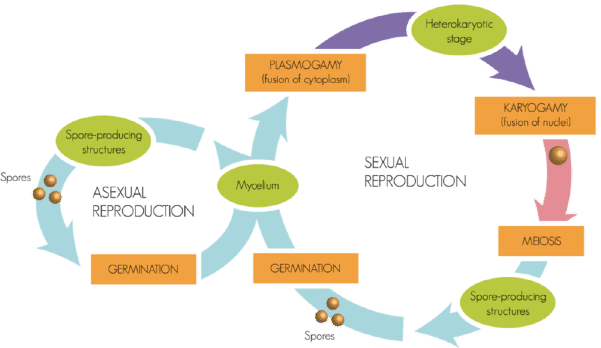

In [626]:
crop

# CK12 flexbook pdf extraction

In [91]:
flexbooks = {
    'life-science': 'CK-12-Life-Science-For-Middle-School_b_v77_dzc_s1.pdf',
    'earth-science': 'CK-12-Earth-Science-For-Middle-School_b_v39_yq9_s1.pdf',
    'physical-science': 'CK-12-Physical-Science-For-Middle-School_b_v45_cmw_s1.pdf'
}

textbook_path = '../ck12/flexbooks/raw-pdfs/text/'
figure_ext_path = '../flexbook_image_extraction/'
rasterized_pages_dir = figure_ext_path +  'pdf_pages/' 
figure_dest_dir = figure_ext_path + 'figures/'

vocab_def_ranges = {
    'life-science': [618, 700],
    'physical-science': [585, 700],
    'earth-science': [591, 592],
    'earth-science': [683, 700],
}

In [42]:
page_range_df = pd.read_csv(textbook_path + 'supplementary/page_ranges.csv', header=None)
range_array = page_range_df.to_dict(orient='split')['data']
range_lookup = {k[0]: k[1:]  for k in range_array}

In [92]:
%%time
parsed_flexbooks = {}
for subject, flexbook_to_parse in flexbooks.items():
    pdf_path = textbook_path + flexbook_to_parse
    parser = ck_ex.TextbookParser(os.path.join(rasterized_pages_dir, 'single_page_images', subject, ''), os.path.join(figure_dest_dir, subject, ''))
    parsed_flexbooks[subject] = parser.parse_pdf(pdf_path, range_lookup[flexbook_to_parse])
#     parsed_flexbooks[subject] = parser.parse_pdf(pdf_path, [5,30])

FIGURE 1.1
FIGURE 1.2
FIGURE 1.3
FIGURE 1.4
FIGURE 1.5
FIGURE 1.6
FIGURE 1.7
FIGURE 1.8
FIGURE 1.9
FIGURE 1.10
FIGURE 1.11
FIGURE 1.12
FIGURE 1.13
FIGURE 1.14
FIGURE 1.15
FIGURE 1.16
FIGURE 1.17
FIGURE 2.1
FIGURE 2.2
FIGURE 2.3
FIGURE 2.4
FIGURE 2.5
FIGURE 2.6
FIGURE 2.7
FIGURE 2.8
FIGURE 2.9
FIGURE 2.10
FIGURE 2.11
FIGURE 2.12
FIGURE 2.13
FIGURE 2.14
FIGURE 2.15
FIGURE 2.16
FIGURE 2.17
FIGURE 2.18
FIGURE 2.19
FIGURE 2.20
FIGURE 2.21
FIGURE 2.22
FIGURE 2.23
FIGURE 2.24
FIGURE 2.25
FIGURE 2.26
FIGURE 2.27
FIGURE 2.28
FIGURE 2.29
FIGURE 2.30
FIGURE 2.31
FIGURE 2.32
FIGURE 2.33
FIGURE 2.34
FIGURE 2.35
FIGURE 2.36
FIGURE 2.37
FIGURE 2.38
FIGURE 2.39
FIGURE 2.40
FIGURE 3.1
FIGURE 3.2
FIGURE 3.3
FIGURE 3.4
FIGURE 3.5
FIGURE 3.6
FIGURE 3.7
FIGURE 3.8
FIGURE 3.9
FIGURE 3.10
FIGURE 3.11
FIGURE 3.12
FIGURE 3.13
FIGURE 3.14
FIGURE 3.15
FIGURE 3.16
FIGURE 3.17
FIGURE 3.18
FIGURE 3.19
FIGURE 3.20
FIGURE 3.21
FIGURE 3.22
FIGURE 3.23
FIGURE 3.24
FIGURE 3.25
FIGURE 3.26
FIGURE 4.1
FIGURE 4.2
FIGURE 4.

In [67]:
%%time
parsed_vocab = {}
for subject, flexbook_to_parse in flexbooks.items():
    pdf_path = textbook_path + flexbook_to_parse
    parser = ck_ex.VocabDefinitionParser(None, None)
    parsed_vocab[subject] = parser.parse_pdf(pdf_path, vocab_def_ranges[subject])

KeyboardInterrupt: 

In [89]:
%%time
parsed_flexbooks_debug = {}
for subject, flexbook_to_parse in flexbooks.items():
    pdf_path = textbook_path + flexbook_to_parse
    parser = ck_ex.TextbookParser(os.path.join(rasterized_pages_dir, 'single_page_images', subject, ''), os.path.join(figure_dest_dir, subject, ''))
    parsed_flexbooks_debug[subject] = parser.parse_pdf(pdf_path, [590, 592])

FIGURE 24.1
../flexbook_image_extraction/figures/earth-science/24.1_Planet_Earth_Earths_Shape_Size_and_Mass_0593_fig_24.1.png
FIGURE 24.2
../flexbook_image_extraction/figures/earth-science/24.1_Planet_Earth_Earths_Shape_Size_and_Mass_0593_fig_24.2.png
CPU times: user 16 s, sys: 426 ms, total: 16.4 s
Wall time: 16.4 s


In [88]:
ls ../flexbook_image_extraction/pdf_pages/single_page_images/

es/ ls/ ps/


In [84]:
5 * 2300 * 0.06

690.0

In [40]:
with open('flexbook_glossary.pkl', 'w') as f:
    pickle.dump(parsed_vocab, f)

## freq distribution

In [ ]:
life_sci_corpus = ''
for topic, lesson in parsed_flexbook.items():
    for lesson_title, content in lesson.items():
        life_sci_corpus += content['text'][0]

lsc_freq_d = nltk.FreqDist(word_tokenize(life_sci_corpus))
# lsc_freq_d.most_common()

# Workbook extraction

In [402]:
workbooks = {
    'life-science': 'CK-12 Life Science For Middle School Workbook (With Answers) 06.01.15.pdf',
    'earth-science': 'CK-12-Earth-Science-For-Middle-School-Workbook-with-Answers.pdf',
    'physical-science': 'CK-12-Physical-Science-For-Middle-School-Workbook-with-Answers.pdf'    
}
workbook_path = '../ck12/flexbooks/raw-pdfs/questions/'

# ends at preview page num -1
# begins at preview page num -2

workbook_q_ranges = {
    'life-science': [7, 291],
    'physical-science': [7, 317],
    'earth-science': [7, 369],
}
workbook_ans_ranges = {
    'life-science': [291, 415],
    'physical-science': [317, 435],
    'earth-science': [370, 506],
} 

In [404]:
%%time
# %%snakeviz
parsed_workbooks = {}
for subject, workbook_to_parse in workbooks.items():
    pdf_path = workbook_path + workbook_to_parse
    wb_parser = ck_ex.WorkbookParser()
#     parsed_workbooks['questions'], parsed_workbooks['answers'] = wb_parser.parse_worksheet_pdf(pdf_path, workbook_q_ranges[subject], workbook_ans_ranges[subject])
    parsed_workbooks[subject] = wb_parser.parse_worksheet_pdf(pdf_path, workbook_q_ranges[subject], workbook_ans_ranges[subject])

'q11'
Lesson 16.2 True or False
'q08'
Lesson 11.2 Multiple Choice
CPU times: user 4min 33s, sys: 3.3 s, total: 4min 37s
Wall time: 4min 37s


In [448]:
test_q_set_wb = deepcopy(parsed_workbooks['earth-science']["2.1 Introduction to Earths Surface"]['questions']['nonDiagramQuestions'])

In [449]:
test_q_set_qt = deepcopy(parsed_quizes['earth-science']["2.1 Introduction to Earths Surface"]['questions']['nonDiagramQuestions'])

In [459]:
if test_q_set_wb:
    renumber_offset = len(test_q_set_wb)
    for old_qn, question in test_q_set_qt.items():
        new_q_n = 'q' + str(int(old_qn[1:]) + renumber_offset).zfill(2)
        test_q_set_wb[new_q_n] = question

In [462]:
test_q_set_wb

{'q01': OrderedDict([('id', 'q01'),
              ('idStructural', '1.'),
              ('beingAsked',
               {'processedText': 'Earths magnetic north pole is always located in the same place.',
                'rawText': '1. Earths magnetic north pole is always located in the same place.'}),
              ('type', 'True or False'),
              ('answerChoices',
               {'a': {'idStructural': 'a.',
                 'processedText': 'true',
                 'rawText': 'a. true'},
                'b': {'idStructural': 'b.',
                 'processedText': 'false',
                 'rawText': 'b. false'}}),
              ('correctAnswer',
               {'processedText': 'false', 'rawText': '1.false'})]),
 'q02': OrderedDict([('id', 'q02'),
              ('idStructural', '2.'),
              ('beingAsked',
               {'processedText': 'A compass needle points toward Earths true north.',
                'rawText': '2. A compass needle points toward Earths true north.

In [425]:
joined_es_flexbook["2.1 Introduction to Earths Surface"]['questions']['nonDiagramQuestions']['q10']

{u'answerChoices': {u'a': {u'idStructural': u'a.',
   u'processedText': u'true',
   u'rawText': u'a. true'},
  u'b': {u'idStructural': u'b.',
   u'processedText': u'false',
   u'rawText': u'b. false'}},
 u'beingAsked': {u'processedText': u'The Mariana Trench is the deepest place on Earth.',
  u'rawText': u'10. The Mariana Trench is the deepest place on Earth.'},
 u'correctAnswer': {u'processedText': u'true', u'rawText': u'10.true'},
 u'id': u'q10',
 u'idStructural': u'10.',
 u'type': u'True or False'}

# Quiz and test extraction

In [522]:
quizes = {
    'life-science': 'CK-12 MS LS Quizzes & Tests (With Answers) 05.27.15.pdf',
#     'earth-science': 'CK-12-Earth-Science-For-Middle-School-Quizzes-and-Tests_qb_v154_olb_s1.pdf',
#     'physical-3science': 'CK-12-Physical-Science-For-Middle-School-Quizzes-and-Tests-with-Answers.pdf'    
}
quiz_path = '../ck12/flexbooks/raw-pdfs/questions/'

# ends at preview page num -1
# begins at preview page num -2

quiz_q_ranges = {
    'life-science': [7, 500],
#     'life-science': [7, 11],
    'physical-science': [7, 500],
    'earth-science': [7, 500],
}

In [523]:
%%time
# parsed_quizes = {}
for subject, quiz_to_parse in quizes.items():
    pdf_path = quiz_path + quiz_to_parse
    qt_parser = ck_ex.QuizTestParser()
    parsed_quizes[subject] = qt_parser.parse_quiz_pdf(pdf_path, quiz_q_ranges[subject])

CPU times: user 50.2 s, sys: 450 ms, total: 50.7 s
Wall time: 50.7 s


In [524]:
# parsed_quizes['life-science']

In [375]:
# sorted(parsed_quizes.keys())

In [388]:
# {name: len(lesson['questions']['nonDiagramQuestions']) for name, lesson in parsed_quizes['life-science'].items()}

In [1005]:
parsed_quizes_clean = deepcopy(parsed_quizes)

for subject, units in parsed_quizes_clean.items():
    for name, lesson in units.items():
        if not len(lesson['questions']['nonDiagramQuestions']) == 15:
            units.pop(name)
        else:
            for question in lesson['questions']['nonDiagramQuestions'].values():
                if question['type'] == 'Fill in the Blanks':
                    question['type'] = 'Fill in the Blank'                

In [1006]:
[q['type'] for q in parsed_quizes_clean['earth-science'].values()[0]['questions']['nonDiagramQuestions'].values()]

['True or False',
 'True or False',
 'Fill in the Blank',
 'Fill in the Blank',
 'True or False',
 'Fill in the Blank',
 'True or False',
 'True or False',
 'Multiple Choice',
 'Multiple Choice',
 'Multiple Choice',
 'Fill in the Blank',
 'Fill in the Blank',
 'Multiple Choice',
 'Multiple Choice']

In [387]:
# {name: len(lesson['questions']['nonDiagramQuestions']) for name, lesson in cleaned_quizes['life-science'].items()}

In [256]:
# subject = 'earth-science'
# pdf_path = '../ck12/flexbooks/raw-pdfs/questions/CK-12-Earth-Science-For-Middle-School-Workbook-with-Answers.pdf'
# qt_parser = ck_ex.WorkbookParser()
# test_parst = qt_parser.parse_worksheet_pdf(pdf_path, [7,11], [370, 372])

# test_parst.values()[0]['questions']['nonDiagramQuestions']

In [41]:
# parsed_quizes.values()[0]['Answer Key']['text']
# parsed_quizes.values()[0]['Lesson Quiz']['text']

# Joining flexbook and workbooks

In [1089]:
ls_flexbook = deepcopy(joined_flexbook_subjects_only['life-science'])
ls_quiz= deepcopy(parsed_quizes_clean['life-science'])
ls_workbook = deepcopy(parsed_workbooks['life-science'])

ps_flexbook = deepcopy(joined_flexbook_subjects_only['physical-science'])
ps_quiz = deepcopy(parsed_quizes_clean['physical-science'])
ps_workbook = deepcopy(parsed_workbooks['physical-science'])


es_flexbook = deepcopy(joined_flexbook_subjects_only['earth-science'])
es_quiz = deepcopy(parsed_quizes_clean['earth-science'])
es_workbook = deepcopy(parsed_workbooks['earth-science'])


ds_assembler = ck_ex.CK12DataSetAssembler()
# joined_ls_flexbook_interm = ds_assembler.join_content_and_questions(ls_flexbook, ls_workbook)
# joined_es_flexbook_interm = ds_assembler.join_content_and_questions(es_flexbook, es_workbook)
# joined_ps_flexbook_interm = ds_assembler.join_content_and_questions(ps_flexbook, ps_workbook)

In [1090]:
# joined_ls_flexbook_exp = ds_assembler.join_content_and_questions(joined_ls_flexbook_interm, ls_quiz)
# joined_es_flexbook_exp = ds_assembler.join_content_and_questions(joined_es_flexbook_interm, es_quiz)
# joined_ps_flexbook_exp = ds_assembler.join_content_and_questions(joined_ps_flexbook_interm, ps_quiz)
joined_ls_flexbook_exp = ds_assembler.join_content_and_questions(ls_flexbook, ls_quiz)
joined_es_flexbook_exp = ds_assembler.join_content_and_questions(es_flexbook, es_quiz)
joined_ps_flexbook_exp = ds_assembler.join_content_and_questions(ps_flexbook, ps_quiz)
joined_flexbook_subjects = {subjects[0]: joined_ls_flexbook_exp, subjects[1]: joined_ps_flexbook_exp, subjects[2]: joined_es_flexbook_exp}


In [1033]:
[q['type'] for q in joined_es_flexbook_exp.values()[0]['questions']['nonDiagramQuestions'].values()]

['Matching',
 'Matching',
 'Matching',
 'Matching',
 u'Fill in the Blank',
 'True or False',
 'True or False',
 'True or False',
 'True or False',
 'Matching',
 'Multiple Choice',
 u'Multiple Choice',
 u'Multiple Choice',
 u'Multiple Choice',
 u'Multiple Choice',
 u'Multiple Choice',
 u'Fill in the Blank',
 u'Fill in the Blank',
 u'Fill in the Blank',
 u'Fill in the Blank',
 u'True or False',
 u'True or False',
 u'True or False',
 u'True or False',
 u'True or False',
 u'True or False',
 'Fill in the Blank',
 'Fill in the Blank',
 'Fill in the Blank',
 'Fill in the Blank',
 'Multiple Choice',
 'Multiple Choice',
 'Multiple Choice',
 'Multiple Choice',
 'Multiple Choice',
 'Multiple Choice',
 u'Matching',
 'Fill in the Blank',
 'Fill in the Blank',
 'Fill in the Blank',
 u'Matching',
 u'Matching',
 u'Matching',
 u'Fill in the Blank',
 u'Matching',
 u'True or False',
 u'Matching',
 u'Matching',
 'True or False',
 'True or False',
 u'Multiple Choice',
 u'Multiple Choice',
 'Matching',
 'Tr

In [1028]:
parsed_quizes_clean['earth-science']['19.2 Pollution of the Land']

{'questions': {'diagramQuestions': {},
  'nonDiagramQuestions': {'q01': OrderedDict([('id', 'q01'),
                ('idStructural', '1. '),
                ('beingAsked',
                 {'processedText': 'At Love Canal',
                  'rawText': '1. At Love Canal'}),
                ('answerChoices',
                 OrderedDict([('a',
                               {'idStructural': 'a.',
                                'processedText': 'the hazardous wastes were safely buried',
                                'rawText': 'a. the hazardous wastes were safely buried'}),
                              ('b',
                               {'idStructural': 'b.',
                                'processedText': 'people became sick right after the town was built',
                                'rawText': 'b. people became sick right after the town was built'}),
                              ('c',
                               {'idStructural': 'c.',
                                'pr

In [993]:
# joined_ls_flexbook_exp.items()[0]

In [426]:
# with open('life_sciparsed_content.json', 'w') as f:
#     json.dump(joined_ls_flexbook, f, indent=4, sort_keys=True)
# with open('phys_sci_parsed_content.json', 'w') as f:
#     json.dump(joined_ps_flexbook, f, indent=4, sort_keys=True)
# with open('earth_sci_parsed_content.json', 'w') as f:
#     json.dump(joined_es_flexbook, f, indent=4, sort_keys=True)

## Dataset verification

In [1393]:
import jsonschema
from pdfextraction import ck12_schema

In [1891]:
ds_assembler = ck_ex.CK12DataSetAssembler()
ds_assembler.validate_schema(smt)

'correctAnswer' is a required property


8th MC question missing an answer

In [1896]:
smt['11.2 Radioactive Decay']['questions']['nonDiagramQuestions']['q15']

{u'answerChoices': {u'a': {u'idStructural': u'a.',
   u'processedText': u'208 Po',
   u'rawText': u'a. 208 Po'},
  u'b': {u'idStructural': u'b.',
   u'processedText': u'131 I  130 Xe + 0 e + Energy',
   u'rawText': u'b. 131 I  130 Xe + 0 e + Energy'},
  u'c': {u'idStructural': u'c.', u'processedText': u'1', u'rawText': u'c. 1'},
  u'd': {u'idStructural': u'd.',
   u'processedText': u'53',
   u'rawText': u'd. 53'}},
 u'beingAsked': {u'processedText': u'Which of the following nuclear equations is balanced?',
  u'rawText': u'8. Which of the following nuclear equations is balanced?'},
 u'id': u'q15',
 u'idStructural': u'8. ',
 u'type': u'Multiple Choice'}

In [1897]:
# validator.validate(smt, ck12_schema.ck12_schema)

# modules and quizes

In [98]:
lessons_path = '/Users/schwenk/wrk/stb/ck12/lessons/'
es_dir ='earth-science'
ls_dir ='life-science'
ps_dir =  'physical-science'

lesson_range = [1, 10]

subject_dirs = [es_dir, ls_dir, ps_dir]
figure_ext_path = '../flexbook_image_extraction/'
rasterized_pages_dir = figure_ext_path +  'lesson_pages/' 

In [20]:
# parsed_lessons_raw ={}
for subject in subject_dirs:
    parsed_lessons_raw[subject] = {}
    for pdf_name in os.listdir(lessons_path + subject):
        lesson_name = pdf_name.replace('.pdf', '')
        print lesson_name
        pdf_path = os.path.join(lessons_path, subject, pdf_name)
        parser = ck_ex.LessonParser(os.path.join(rasterized_pages_dir, 'single_page_images', subject, ''), os.path.join(figure_dest_dir, subject, ''))
        parsed_lessons_raw[subject][lesson_name] = parser.parse_pdf(pdf_path, lesson_range)

21st-Century-Tsunami-HS-ES
Acid-Rain-HS-ES
Adaptation-and-Evolution-of-Populations-HS-ES
Age-of-Earth-HS-ES
Agriculture-and-Human-Population-Growth-HS-ES
Air-Masses-HS-ES
Air-Quality-HS-ES
Asteroids-HS-ES
Atoms-to-Molecules-HS-ES
Availability-of-Natural-Resources-HS-ES
Avoiding-Soil-Loss-HS-ES
Bathymetric-Evidence-for-Seafloor-Spreading-HS-ES
Big-Bang-HS-ES
Biological-Communities-HS-ES
Blizzards-HS-ES
Branches-of-Earth-Science-HS-ES
Carbon-Cycle-and-Climate-HS-ES
Causes-Of-Air-Pollution-HS-ES
Cenozoic-Plate-Tectonics-HS-ES
Characteristics-and-Origins-of-Life-HS-ES
Chemical-Bonding-HS-ES
Chemical-Weathering-HS-ES
Circulation-in-the-Atmosphere-HS-ES
Cleaning-Up-Groundwater-HS-ES
Climate-Change-in-Earth-History-HS-ES
Climate-Zones-and-Biomes-HS-ES
Clouds-HS-ES
Coal-Power-HS-ES
Coastal-Pollution-HS-ES
Collecting-Weather-Data-HS-ES
Comets-HS-ES
Composition-of-the-Atmosphere-HS-ES
Conserving-Water-HS-ES
Continent-Continent-Convergent-Plate-Boundaries-HS-ES
Continental-Drift-HS-ES
Coriolis-Ef

In [21]:
parsed_lessons = deepcopy(parsed_lessons_raw)

In [23]:
parsed_lessons['earth-science'].keys()

['Galaxies-HS-ES',
 'Principle-of-Horizontality-HS-ES',
 'Correlation-Using-Relative-Ages-HS-ES',
 'Universe-HS-ES',
 'Importance-of-the-Oceans-HS-ES',
 'Surface-Ocean-Currents-HS-ES',
 'Continent-Continent-Convergent-Plate-Boundaries-HS-ES',
 'Geological-Stresses-HS-ES',
 'History-of-Mesozoic-Life-HS-ES',
 'Paleozoic-Plate-Tectonics-HS-ES',
 'Water-Pollution-HS-ES',
 'Hydroelectric-Power-HS-ES',
 'Preventing-Hazardous-Waste-Problems-HS-ES',
 'Impacts-of-Hazardous-Waste-HS-ES',
 'Hazardous-Waste-HS-ES',
 'Mountain-Building-HS-ES',
 'Scientific-Explanations-and-Interpretations-HS-ES',
 'Geologic-Time-Scale-HS-ES',
 'Early-Atmosphere-and-Oceans-HS-ES',
 'Metamorphic-Rock-Classification-HS-ES',
 'Landforms-from-Wave-Erosion-and-Deposition-HS-ES',
 'Reducing-Air-Pollution-HS-ES',
 'Ocean-Continent-Convergent-Plate-Boundaries-HS-ES',
 'Mesosphere-HS-ES',
 'Heat-Transfer-in-the-Atmosphere-HS-ES',
 'Principle-of-Uniformitarianism-HS-ES',
 'Coal-Power-HS-ES',
 'Measuring-Earthquake-Magnitude-H

In [25]:
with open('all_lessons_v1.json', 'w') as f:
    json.dump(parsed_lessons, f, indent=4, sort_keys=True)

In [27]:
def normalize_keys(parsed_lessons):
    normalized_lessons = deepcopy(parsed_lessons)
    for k in normalized_lessons.keys():
        if k[-1] == 'S':
            norm_k = k[:-6]
        norm_k = norm_k.replace('-', ' ').lower().strip()
        normalized_lessons[norm_k] = normalized_lessons.pop(k).values()[-1]
    return normalized_lessons

In [28]:
norm_lessons = {sub: normalize_keys(lessons) for sub, lessons in parsed_lessons.items()}

In [29]:
norm_lessons['physical-science'].keys()

['mass vs weight',
 'static electricity and static discharge',
 'ionic bonding',
 'valence electrons',
 'enzymes as catalysts',
 'calculating work',
 'scientific notation',
 'electric charge and electric force',
 'chemical reaction rate',
 'half life and radioactive dating',
 'electric power and electrical energy use',
 'acceleration due to gravity',
 'electron cloud atomic model',
 'scientific process',
 'artificial light',
 'lever',
 'combustion reactions',
 'force',
 'energy conversion',
 'groups with metalloids',
 'scientific modeling',
 'rutherfords atomic model',
 'carbon bonding',
 'air pressure and altitude',
 'atoms',
 'amontons law',
 'physical properties of matter',
 'synthesis reactions',
 'vision problems and corrective lenses',
 'hearing loss',
 'alpha decay',
 'scientific law',
 'ions',
 'scientific graphing',
 'nuclear fission',
 'musical instruments',
 'balancing chemical equations',
 'electronic signal',
 'elastic force',
 'atomic nucleus',
 'ohms law',
 'gamma decay'

In [58]:
with open('./all_parsed_quiz_questions_v1.json') as f:
    parsed_quizes = json.load(f)

In [102]:
lesson_flexbook = deepcopy(norm_lessons)
lesson_quiz = deepcopy(parsed_quizes)

joined_subjects = {}
for subject in subject_dirs:
    print subject
    print '\n'*2
    ds_assembler = ck_ex.CK12DataSetAssembler()
    joined_subjects[subject] = ds_assembler.join_content_and_questions(lesson_flexbook[subject], lesson_quiz[subject])
    print '\n'*2

earth-science



topic mismatch, attempting to match keys: set(['ocean continent convergent plate boundaries', 'evolution plate tectonics and climate change', 'inner vs. outer planets', 'nitrogen cycle in ecosystems', 'divergent plate boundaries in the oceans', 'transform plate boundaries', 'distribution of water on earth', 'global wind belts', 'non renewable energy resources', 'earth science field work', 'hydroelectric power', 'effect of atmospheric circulation on climate', 'long term climate change', 'plate tectonics through earth history', 'importance of the oceans', 'fresh water ecosystems', 'intraplate earthquakes', 'adaptation and evolution of populations', 'the history of astronom', 'landforms from groundwater erosion and deposition', 'the hertzsprung russell diagra', 'geologic time scale', 'tree rings ice cores and varves', 'mid latitude cyclones', 'short term climate change', 'renewable vs non renewable energy resources', 'intrusive and extrusive igneous rocks', 'overpopulatio

## weird misses

oceancontinent convergent plate boundaries

In [92]:
sorted(lesson_quiz['earth-science'].keys())[179]

u'obtaining energy resources'

In [91]:
sorted(lesson_quiz['earth-science'].keys())[180]

'ocean continent convergent plate boundaries'

In [97]:
sorted(lesson_quiz['earth-science'].keys())

[u'21st century tsunami',
 u'acid rain',
 'adaptation and evolution of populations',
 u'age of earth',
 u'agriculture and human population growth',
 u'air masses',
 u'air quality',
 u'asteroids',
 u'atmospheric circulation',
 u'availability of natural resources',
 u'avoiding soil loss',
 u'bathymetric evidence for seafloor spreading',
 u'big bang',
 u'biological communities',
 u'blizzards',
 u'branches of earth science',
 u'carbon cycle and climate',
 u'causation and correlation',
 u'causes of air pollution',
 u'cenozoic plate tectonics',
 u'characteristics and origins of life',
 u'chemical bonding',
 u'chemical weathering',
 u'cleaning up groundwater',
 u'climate change in earth history',
 u'climate zones and biomes',
 u'clouds',
 u'coal power',
 u'coastal pollution',
 u'collecting weather data',
 u'comets',
 u'composition of the atmosphere',
 u'conserving water',
 u'continental drift',
 u'continentcontinent convergent plate boundaries',
 u'coriolis effect',
 u'correlation using relat

In [81]:
sorted(lesson_flexbook['earth-science'].keys())

['21st century tsunami',
 'acid rain',
 'adaptation and evolution of populations',
 'age of earth',
 'agriculture and human population growth',
 'air masses',
 'air quality',
 'asteroids',
 'atoms to molecules',
 'availability of natural resources',
 'avoiding soil loss',
 'bathymetric evidence for seafloor spreading',
 'big bang',
 'biological communities',
 'blizzards',
 'branches of earth science',
 'carbon cycle and climate',
 'causes of air pollution',
 'cenozoic plate tectonics',
 'characteristics and origins of life',
 'chemical bonding',
 'chemical weathering',
 'circulation in the atmosphere',
 'cleaning up groundwater',
 'climate change in earth history',
 'climate zones and biomes',
 'clouds',
 'coal power',
 'coastal pollution',
 'collecting weather data',
 'comets',
 'composition of the atmosphere',
 'conserving water',
 'continent continent convergent plate boundaries',
 'continental drift',
 'coriolis effect',
 'correlation and causation',
 'correlation using relative ag

In [66]:
# pprint.pprint(joined_subject['respiration']['questions']['nonDiagramQuestions'])

In [108]:
# sorted(lesson_flexbook['earth-science'].keys())
# sorted(lesson_quiz['earth-science'].keys())
lks = set(lesson_flexbook['earth-science'].keys())
qks = set(lesson_quiz['earth-science'].keys())
lks.difference(qks)

set()

In [110]:
sorted(list(qks.difference(lks)))

[u'atmospheric circulation',
 u'causation and correlation',
 u'continentcontinent convergent plate boundaries',
 u'development of theories second version',
 u'effect of altitude and mountain ranges',
 u'energy conservation second version',
 u'evolution of eukaryotes',
 u'field trips',
 u'igneous',
 u'landforms ii: erosion & deposition by groundwater',
 u'oceancontinent convergent plate boundaries',
 u'oceanocean convergent plate boundaries',
 u'renewable and nonrenewable resources',
 u'telescopes',
 u'the life cycle of a star']

In [ ]:
removing ocean continent convergent plate boundaries
removing life cycles of stars
removing igneous rock classification
removing earth science field work
removing hydroelectric power
removing effect of atmospheric circulation on climate
removing flow of energy in ecosystems
removing reducing greenhouse gas pollution
removing landforms from wind erosion and deposition
removing renewable vs non renewable energy resources
removing ocean ocean convergent plate boundaries
removing inner versus outer planets
removing effect of altitude and mountains on climate
removing continent continent convergent plate boundaries
removing renewable energy resources
removing seafloor
removing landforms from wave erosion and deposition
removing evolution of eukaryotes to multicellular life
removing introduction to energy resources
removing circulation in the atmosphere
removing landforms from stream erosion and deposition
removing renewable vs. non renewable energy resources
removing atoms to molecules
removing correlation and causation

## verify

In [106]:
for subject, joined_content in joined_subjects.items():
    ds_assembler = ck_ex.CK12DataSetAssembler()
    print subject
    ds_assembler.validate_schema(joined_content)
    print

earth-science

life-science

physical-science



In [111]:
with open('combined_lessons_and_quizes_v1.json', 'w') as f:
    json.dump(joined_subjects, f, indent=4, sort_keys=True)

# combining lessons and flexbook content

loading flexbook and lesson data from disk

In [1079]:
output_dir = 'output_data_from_nbs/'
subjects = ['life-science', 'physical-science', 'earth-science']

# with open(output_dir + 'combined_lessons_and_quizes_v1.json', 'r') as f:
#     joined_lessons = json.load(f)

joined_flexbook_subjects_only = {}

with open(output_dir + 'life_sciparsed_content.json', 'r') as f:
    joined_flexbook_subjects_only[subjects[0]] = json.load(f)
with open(output_dir+ 'phys_sci_parsed_content.json', 'r') as f:
    joined_flexbook_subjects_only[subjects[1]] = json.load(f)
with open(output_dir + 'earth_sci_parsed_content.json', 'r') as f:
    joined_flexbook_subjects_only[subjects[2]] = json.load(f)

In [1096]:
# sorted([q['beingAsked']['rawText'] for q in joined_flexbook_subjects['earth-science']['2.1 Introduction to Earths Surface']['questions']['nonDiagramQuestions'].values()])

In [1072]:
q_types = []
# for subject, flexbook in {'earth-science': joined_es_flexbook_interm}.items():
for subject, flexbook in ck12_dataset_beta.items():
    for lesson in flexbook.values():
        for question in lesson['questions']['nonDiagramQuestions'].values():
            q_types.append(question['type'])
question_counts = pd.Series(q_types).value_counts()
print 'total number of questions = ' + str(question_counts.sum())
question_counts

total number of questions = 25946


Multiple Choice      8234
True or False        7873
Fill in the Blank    4905
Matching             3338
Short Answer         1596
dtype: int64

In [1092]:
ck12_dataset_beta = {k: dict(v, **joined_flexbook_subjects[k]) for k, v in joined_lessons.items()}

In [1093]:
with open(output_dir + 'ck12_flexbook_only_beta_v3.json', 'w') as f:
    json.dump(joined_flexbook_subjects, f, indent=4, sort_keys=True)

In [1094]:
with open(output_dir + 'ck12_lessons_only_beta_v3.json', 'w') as f:
    json.dump(joined_lessons, f, indent=4, sort_keys=True)

In [1095]:
with open(output_dir + 'ck12_dataset_beta_v3.json', 'w') as f:
    json.dump(ck12_dataset_beta, f, indent=4, sort_keys=True)

# Lower grade levels

In [62]:
textbook_path = '../data/lower_grade_flexbooks/'
rasterized_pages_dir = textbook_path + 'single_page_images/'
lower_grade_books = {
    '5th': 'CK-12-Fifth-Grade-Science_b_v8_cpx_s1.pdf',
#     '1st': 'CK-12-First-Grade-Science_b_v13_khz_s1.pdf',
    '4th': 'CK-12-Fourth-Grade-Science_b_v4_jyz_s1.pdf',
#     '2nd': 'CK-12-Second-Grade-Science_b_v9_zpx_s1.pdf',
    '3rd': 'CK-12-Third-Grade-Science_b_v31_kov_s1.pdf'
}

In [63]:
parsed_lower_grades = {}
for grade, flexbook_to_parse in lower_grade_books.items():
    pdf_path = textbook_path + flexbook_to_parse
    gs_parser = ck_ex.GradeSchoolFlexbookParser(os.path.join(rasterized_pages_dir, 'single_page_images', grade, ''), 'extracted_figs/')
    parsed_lower_grades[grade] = gs_parser.parse_pdf(pdf_path, [4,200])

In [1834]:
parsed_lower_grades['3rd'].keys()

['1.5 Static Electricity',
 '2.2 World Climates',
 '3.2 Insect Reproduction and Life Cycles',
 '1.2 Friction',
 '2.3 Fossils of Plants and Animals',
 '3.1 Adaptation and Natural Selection',
 '1.1 Forces',
 '1.4 Magnets',
 '3.4 Plant Reproduction and Life Cycles',
 '3.3 Plant Adaptations to Environmental',
 '1.3 Gravity',
 '3.5 Animal Characteristics and Classification',
 '2.1 Weather Forecasting']

In [1885]:
parsed_lower_grades_cleaned = {}
for grade, flexbook_to_parse in parsed_lower_grades.items():
    single_grade_content = deepcopy(flexbook_to_parse)

    local_path = 'extracted_figs/'
    s3_uri = 'https://s3.amazonaws.com/ai2-vision-textbook-dataset/ck12/flexbooks/extracted-figures/'
    for lesson, subcontent in single_grade_content.items():
        for concept, content in subcontent.items():
            if content['text']:
                content['text'] = content['text'][0]
            for fig in content['figures']:
                fig['image_uri'] = fig['file_name'].replace(local_path, s3_uri)
                del fig['rectangle']
                del fig['file_name']
    parsed_lower_grades_cleaned[grade] = single_grade_content

In [1886]:
parsed_lower_grades_cleaned['3rd'].keys()

['3.5 Animal Characteristics and Classification',
 '2.2 World Climates',
 '3.1 Adaptation and Natural Selection',
 '2.3 Fossils of Plants and Animals',
 '1.2 Friction',
 '1.1 Forces',
 '1.5 Static Electricity',
 '3.4 Plant Reproduction and Life Cycles',
 '3.3 Plant Adaptations to Environmental',
 '2.1 Weather Forecasting',
 '1.3 Gravity',
 '3.2 Insect Reproduction and Life Cycles',
 '1.4 Magnets']

In [1867]:
toc = {}
chapter_titles = defaultdict(list)
for single_grade, val in parsed_lower_grades.items():
    toc[single_grade] = sorted(val.keys())
#     print
#     for chapter in sorted(val.keys()):
#         chapter_titles[single_grade].append(chapter)

In [1828]:
chapter_titles

defaultdict(list,
            {'3rd': ['1.1 Atoms',
              '1.1 Forces',
              '1.1 Types of Energy',
              '1.10 Electric Current',
              '1.10 Magnets and Magnetism',
              '1.11 Earth as a Magnet',
              '1.11 Electric Circuits',
              '1.12 Speed',
              '1.2 Characteristics of Sound',
              '1.2 Friction',
              '1.2 Types of Matter',
              '1.3 Forms and Changes of Energy',
              '1.3 Gravity',
              '1.3 Matter, Mass, and Volume',
              '1.4 Magnets',
              '1.4 Solid, Liquid and Gases',
              '1.4 Transfer of Thermal Energy',
              '1.5 Energy Resources',
              '1.5 Physical Properties of Matter',
              '1.5 Static Electricity',
              '1.6 Chemical Properties of Matter',
              '1.6 Moving Air and Water as Energy Sources',
              '1.7 Physical and Chemical Changes in Matter',
              '1.7 Reflection of

In [1869]:
with open('science_gr_3_to_5_chapters.json', 'w') as f:
    json.dump(toc, f, indent=4, sort_keys=True)

In [435]:
lesson_names = [item for sublist in [val.keys() for val in single_grade_content.values()] for item in sublist]
pd.Series(lesson_names).value_counts()

Lesson Review Questions                               13
Lesson Objectives                                     13
Lesson Summary                                        12
Lesson Vocabulary                                     12
Recall                                                 8
Apply Concepts                                         8
Introduction                                           8
External Resources                                     6
Think Critically                                       6
MEDIA                                                  4
Points to Consider                                     3
Microclimates                                          1
Fossil Clues                                           1
Plant Responses                                        1
How Fossils Form                                       1
How Can Gravity Be Overcome?                           1
Insect Reproduction and Life Cycle                     1
Vertebrate Animals             

In [1890]:
with open('../data/parsed_data_json/flexbook_g3_science.json', 'w') as f:
    json.dump(parsed_lower_grades_cleaned['3rd'], f, indent=4, sort_keys=True)

# Removing media links

In [969]:
joined_flexbook_subjects['life-science'].keys()

[u'19.1 The Respiratory System',
 u'9.1 Protists',
 u'1.4 The Microscope',
 u'1.3 The Scientific Method',
 u'15.1 Understanding Animal Behavior',
 u'16.1 Introduction to the Human Body',
 u'16.4 The Muscular System',
 u'8.1 Introduction to Prokaryotes',
 u'12.4 Insects and Other Arthropods',
 u'6.3 Advances in Genetics',
 u'18.2 Heart and Blood Vessels',
 u'7.1 Darwins Theory of Evolution',
 u'1.5 Safety in Life Science Research',
 u'22.3 Reproduction and Life Stages',
 u'11.1 What Are Animals',
 u'7.2 Evidence for Evolution',
 u'9.2 Fungi',
 u'17.2 Choosing Healthy Foods',
 u'20.1 The Nervous System',
 u'12.3 Mollusks and Annelids',
 u'24.1 Flow of Energy',
 u'13.1 Introduction to Vertebrates',
 u'21.2 Noninfectious Diseases',
 u'10.1 Introduction to Plants',
 u'4.1 Transport',
 u'13.4 Reptiles',
 u'14.1 Birds',
 u'6.2 Introduction to Genetics',
 u'18.3 Blood',
 u'21.3 First Two Lines of Defense',
 u'23.3 Communities',
 u'10.2 Evolution and Classification of Plants',
 u'8.2 Bacteria',

In [971]:
tlcs = joined_flexbook_subjects['life-science']['25.2 Water Pollution']['topics'].values()

In [973]:
pat_str = "(?:https?:\/\/(?:www\.).*?\s)"
# pat_str = "(http(s?):\/\/)?(www\.)*?youtu(be)?\.([a-z])+\/(watch(.*?)(\?|\&)v=)?(.*?)(&(.)*)?"

# pat_str = "sweat(s?))"

web_link_patern=re.compile(pat_str)
def clean_content_text(content_str, web_link_patern):
    removed_links = web_link_patern.findall(content_str)
    split_txt = web_link_patern.split(content_str)
    cleaned_text = ' '.join([txt for txt in split_txt if txt])
    return cleaned_text, [link.strip() for link in removed_links]

In [976]:
# clean_content_text(tlcs, web_link_patern)

In [977]:
[clean_content_text(cs['content']['text'], web_link_patern) for cs in tlcs]

[(u'algal bloom\ndead zone\nnonpoint-source pollution\nocean acidification\npoint-source pollution\nthermal pollution\nwaterborne disease\nwater pollution\nwetland\n',
  []),
 (u'Water pollution occurs when chemicals, sewage, trash, or heat enter water resources. Water pollution is threatening the limited supply of clean, fresh water that human beings and other living things depend on. Fertilizer in runoff leads to algal blooms and dead zones in bodies of water. This type of pollution is called nonpoint-source pollution. Point-source pollution includes waste water from factories and sewage treatment plants. Hot water discharge causes thermal pollution. The ocean is becoming increasingly polluted with trash. Ocean acidification is also occurring because ocean water dissolves some of the excess carbon dioxide in the atmosphere. The more acidic water harms aquatic organisms. ',
  []),
 (u'When fertilizer ends up in bodies of water, the added nutrients cause excessive growth of algae. This

# End

In [ ]:
# flatq = [len(sect.values()[0]) for sect in parsed_workbooks.values()[0].values()]
# sum(flatq)

In [ ]:
lesson_names = [item for sublist in [val.keys() for val in combined_flexbook_content.values()] for item in sublist]
pd.Series(lesson_names).value_counts()[:11]

In [ ]:
qtypes = []

for lesson in parsed_questions.values():
    qtypes.append(len(lesson['nonDiagramQuestions'].keys()))
pd.Series(qtypes).value_counts()

In [ ]:
for subject, workbook_to_parse in workbooks.items():
    pdf_path = workbook_path + workbook_to_parse
    wb_parser = ck_ex.WorkbookParser()
    parsed_questions = wb_parser.parse_worksheet_pdf(pdf_path, workbook_q_ranges[subject], workbook_ans_ranges[subject])